In [2]:
%matplotlib inline

import glob
import os
import sys
import math
import copy
import joblib


import scipy as sp
from scipy import ndimage as ndi
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import mcnemar

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm

import sys; 
import numpy as np
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from typing import Optional, Union
from numpy import array, argmax, load

import warnings
warnings.filterwarnings("ignore")
Path="/content/drive/MyDrive/"

import cv2
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np
import zipfile
import joblib
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


import skimage
from skimage.color import rgb2hed
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
from skimage.morphology import area_opening
from skimage.segmentation import mark_boundaries

import lime; from lime import lime_image

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
clf_resnet = joblib.load(Path+'LRmodel.pkl')#resnet_block1_log_scaled

In [4]:
gene_list_2 = ['CD74','CD24', 'CD63', 'CD81', 'CD151', 
               'COX6C', 'TP53', 'PABPC1', 'GNAS', 'B2M', 'SPARC', 'HSP90AB1', 'TFF3', 'ATP1A1', 'FASN']
resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")

def model_predict_gene(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf_resnet.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)
    thresh = skimage.filters.threshold_otsu(annotation_h)*0.7
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def cell_summary(file_path,cell_type_input):
    cell_summary_tile = pd.read_csv(file_path)
    return cell_summary_tile.loc[(cell_summary_tile['cell_type'].isin(cell_type_input))]

def true_tumor_nuclie_mask(img_path):
    image = cv2.imread(img_path)
    lower = np.array([0, 255, 0], dtype="uint8")
    upper = np.array([0, 255, 0], dtype="uint8")
    mask = cv2.inRange(image, lower, upper)
    mask[mask==255] = 1
    return mask

def true_immune_nuclei_mask(img_path):
    image = cv2.imread(img_path)
    image[:,:,1] = 0
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask[mask==105] = 0
    mask[mask>0] = 1
    return mask

def IOU_mask_per_gene(True_mask, Lime_mask):
    Lime_mask[Lime_mask == -1] = 0
    true_masks = True_mask+Lime_mask
    false_masks = Lime_mask-True_mask
    TP = (true_masks==2).sum()
    TN = (true_masks==0).sum()
    FP = (false_masks==1).sum()
    FN = (false_masks==-1).sum()
    confusion_matrix = [[TN, FP], [FN, TP]]
    return confusion_matrix

def IOU_mask_multiple_gene(True_mask, Lime_mask):
    Lime_mask[Lime_mask > 0] = 1
    Lime_mask[Lime_mask < 0] = 0
    true_masks = True_mask+Lime_mask
    false_masks = Lime_mask-True_mask
    TP = (true_masks==2).sum()
    TN = (true_masks==0).sum()
    FP = (false_masks==1).sum()
    FN = (false_masks==-1).sum()
    confusion_matrix = [[TN, FP], [FN, TP]]
    return confusion_matrix

def IOU_coordinates(Ref_mask,Lime_mask):
    Lime_mask[Lime_mask == -1] = 0
    coordinate_x = np.array(round(Ref_mask['coordinate_x'])).astype('int64')
    coordinate_y = np.array(round(Ref_mask['coordinate_y'])).astype('int64')
    mask_initialised = np.array([[0]*299]*299)
    mask_initialised[coordinate_x,coordinate_y] = 1
    overlap = mask_initialised*Lime_mask # Logical AND
    return overlap.sum()/float(mask_initialised.sum())

def LIME_p_value(heatmap_cancer, heatmap_immune, cell_summary_Tumor, cell_summary_lymphocyte_stroma):

    tumor_lime_score = []; immune_lime_score = []; tumor = []; immune = []

    for i in range(0,len(cell_summary_Tumor)):
        xt_cord = np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')  
        yt_cord = np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')
        if heatmap_cancer[xt_cord][yt_cord]>0:
            tumor_lime_score.append(heatmap_cancer[xt_cord][yt_cord])

    for j in range(0,len(cell_summary_lymphocyte_stroma)):
        xi_cord = np.round(cell_summary_lymphocyte_stroma['coordinate_x'][j]).astype('int64')  
        yi_cord = np.round(cell_summary_lymphocyte_stroma['coordinate_y'][j]).astype('int64')
        if heatmap_immune[xi_cord][yi_cord]>0:
            immune_lime_score.append(heatmap_immune[xi_cord][yi_cord])

    incorrect_tumor = len(cell_summary_Tumor)-len(tumor_lime_score)
    correct_tumor = len(tumor_lime_score)
    incorrect_immune = len(cell_summary_lymphocyte_stroma)-len(immune_lime_score)
    correct_immune = len(immune_lime_score)
    score_table = [[correct_tumor,incorrect_tumor],[incorrect_immune,correct_immune]]

    accuracy = ["Accuracy of Tumor Nuclei is:",correct_tumor/len(cell_summary_Tumor),"Accuracy of Immune Nuclei is:",correct_immune/len(cell_summary_lymphocyte_stroma),
              "Average Accuracy of LIME Model is:",(correct_tumor+correct_immune)/(len(cell_summary_Tumor)+len(cell_summary_lymphocyte_stroma))]

    return score_table, accuracy

explainer = lime_image.LimeImageExplainer()

94781440/94765736 [==============================] - 2s 0us/step


In [5]:
images = []
image_dir = glob.glob(os.path.join(Path, "LIME/FFPE/*.jpeg"))
for image in image_dir:
    images.append(np.asarray(image_fun.load_img(image)))
#images = [images[0],images[1], images[2], images[3], images[4]]

immune_genes = ['CD74','CD24', 'CD151']
cancer_genes = ['COX6C','PABPC1', 'B2M']

immune_masks = []; immune_temp = []; heatmap_immune = []
cancer_masks = []; cancer_temp = []; heatmap_cancer = []
for n in range(0,len(images)):
    for i in range(0,len(immune_genes)):
        explanation_i = explainer.explain_instance(images[n], model_predict_gene(immune_genes[i]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
        temp_i, mask_i = explanation_i.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
        immune_masks.append(mask_i)
        immune_temp.append(temp_i)
        dict_heatmap_i = dict(explanation_i.local_exp[1])
        heatmap_i = np.vectorize(dict_heatmap_i.get)(explanation_i.segments)
        heatmap_immune.append(heatmap_i)
    for j in range(0,len(cancer_genes)):
        explanation_c = explainer.explain_instance(images[n], model_predict_gene(cancer_genes[j]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
        temp_c, mask_c = explanation_c.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
        cancer_masks.append(mask_c)
        cancer_temp.append(temp_c)
        dict_heatmap_c = dict(explanation_c.local_exp[1])
        heatmap_c = np.vectorize(dict_heatmap_c.get)(explanation_c.segments)
        heatmap_cancer.append(heatmap_c)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
true_img_masks_dir = glob.glob(os.path.join(Path, "LIME/FFPE/*.png"))
#true_img_masks_dir = [true_img_masks_dir[0],true_img_masks_dir[1]]
true_tumor_masks_webtool = []; true_immune_masks_webtool = []
for image in true_img_masks_dir:
    true_tumor_masks_webtool.append(true_tumor_nuclie_mask(image))
    true_immune_masks_webtool.append(true_immune_nuclei_mask(image))

In [13]:
cm_per_gene_tumor = []; cm_per_gene_immune = []
for i in range(0,len(true_tumor_masks_webtool)):
    cm_per_gene_tumor.append(IOU_mask_per_gene(true_tumor_masks_webtool[i],cancer_masks[i]))
    cm_per_gene_immune.append(IOU_mask_per_gene(true_immune_masks_webtool[i],immune_masks[i]))

In [14]:
heatmap_cancer_gene_total = np.add.reduceat(heatmap_cancer, np.arange(0, len(heatmap_cancer), len(cancer_genes)))
heatmap_immune_gene_total = np.add.reduceat(heatmap_immune, np.arange(0, len(heatmap_immune), len(immune_genes)))

cm_multiple_gene_tumor = []; cm_multiple_gene_immune = []
for i in range(0,len(true_tumor_masks_webtool)):
    cm_multiple_gene_tumor.append(IOU_mask_multiple_gene(true_tumor_masks_webtool[i],heatmap_cancer_gene_total[i]))
    cm_multiple_gene_immune.append(IOU_mask_multiple_gene(true_immune_masks_webtool[i],heatmap_immune_gene_total[i]))

In [26]:
p_val_immune_fisher_exact = []; p_val_tumor_fisher_exact = []
sensitivity_immune = []; specificity_immune = []; precision_immune = []
sensitivity_tumor = []; specificity_tumor = []; precision_tumor = []
accuracy_immune = []; accuracy_tumor = []

for i in range(0,len(cm_multiple_gene_immune)):
    p_val_immune_fisher_exact.append(fisher_exact(cm_multiple_gene_immune[i], alternative='two-sided')[1])
    p_val_tumor_fisher_exact.append(fisher_exact(cm_multiple_gene_tumor[i], alternative='two-sided')[1])

    sensitivity_immune.append((cm_multiple_gene_immune[i][1][1])/(cm_multiple_gene_immune[i][1][1]+cm_multiple_gene_immune[i][1][0]))
    sensitivity_tumor.append((cm_multiple_gene_tumor[i][1][1])/(cm_multiple_gene_tumor[i][1][1]+cm_multiple_gene_tumor[i][1][0]))

    specificity_immune.append((cm_multiple_gene_immune[i][0][0])/((cm_multiple_gene_immune[i][0][0])+(cm_multiple_gene_immune[i][0][1])))
    specificity_tumor.append((cm_multiple_gene_tumor[i][0][0])/((cm_multiple_gene_tumor[i][0][0])+(cm_multiple_gene_tumor[i][0][1])))

    precision_immune.append((cm_multiple_gene_immune[i][1][1])/((cm_multiple_gene_immune[i][1][1])+(cm_multiple_gene_immune[i][0][1])))
    precision_tumor.append((cm_multiple_gene_tumor[i][1][1])/((cm_multiple_gene_tumor[i][1][1])+(cm_multiple_gene_tumor[i][0][1])))

    accuracy_immune.append((cm_multiple_gene_immune[i][1][1]+cm_multiple_gene_immune[i][0][0])/(cm_multiple_gene_immune[i][1][1]+cm_multiple_gene_immune[i][1][0]+
                                                                                                cm_multiple_gene_immune[i][0][0]+cm_multiple_gene_immune[i][0][1]))
    accuracy_tumor.append((cm_multiple_gene_tumor[i][1][1]+cm_multiple_gene_tumor[i][0][0])/(cm_multiple_gene_tumor[i][1][1]+cm_multiple_gene_tumor[i][1][0]+
                                                                                             cm_multiple_gene_tumor[i][0][0]+cm_multiple_gene_tumor[i][0][1]))

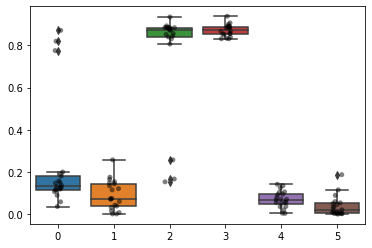

In [27]:
all_scores_immune_tumor = [sensitivity_immune, sensitivity_tumor,
                     specificity_immune, specificity_tumor,
                     precision_immune, precision_tumor]

sns.boxplot(data=all_scores_immune_tumor)
sns.stripplot(data=all_scores_immune_tumor,color = 'black',alpha = 0.5)

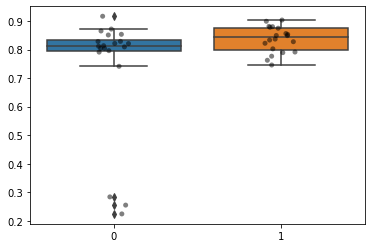

In [28]:
accuracy = [accuracy_immune, accuracy_tumor]
sns.boxplot(data=accuracy)
sns.stripplot(data=accuracy,color = 'black',alpha = 0.5)

(-0.25, 0.5)

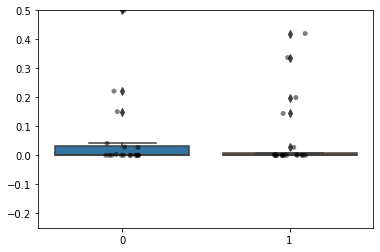

In [30]:
fisher_exact_test_p_val = [p_val_immune_fisher_exact, p_val_tumor_fisher_exact]
sns.boxplot(data=fisher_exact_test_p_val)
sns.stripplot(data=fisher_exact_test_p_val,color = 'black',alpha = 0.5)
plt.ylim([-0.25,0.5])